In [235]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,  KFold
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge, Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

EDA and preprocessing

In [236]:
data = pd.read_csv('train.csv')
print(data.shape)
data.head(3)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [237]:
# Drop unneeded column
data.drop('Id', axis = 1, inplace=True)

# Drop all columns with >= 50% NaN values
threshold = len(data) * 0.5
cols_to_drop = data.columns[data.isnull().sum() >= threshold]
data.drop(cols_to_drop, axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

print("Columns missing at least 50 percent of values:\n", cols_to_drop)
print(data.shape)

Columns missing at least 50 percent of values:
 Index(['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')
(1460, 75)


Visualizing the data

C:\Users\rtesi\AppData\Local\Temp\ipykernel_24192\1402388490.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['SalePrice'], shade=True, color='red', label='SalePrice')


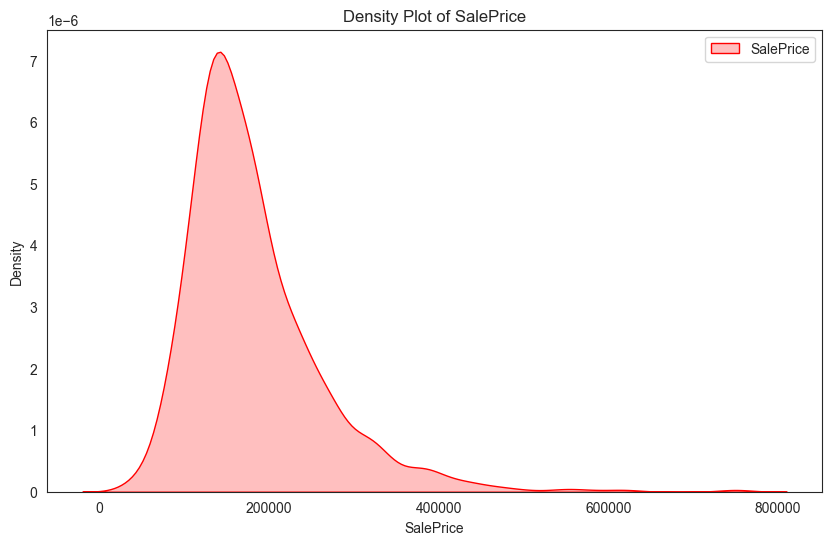

In [238]:
# Visualize distribution of target variable
plt.figure(figsize=(10, 6))
sns.kdeplot(data['SalePrice'], shade=True, color='red', label='SalePrice')
plt.title('Density Plot of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.legend()
plt.show()

C:\Users\rtesi\AppData\Local\Temp\ipykernel_24192\3857337193.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['SalePrice'], shade=True, color='green', label='Log(SalePrice)')


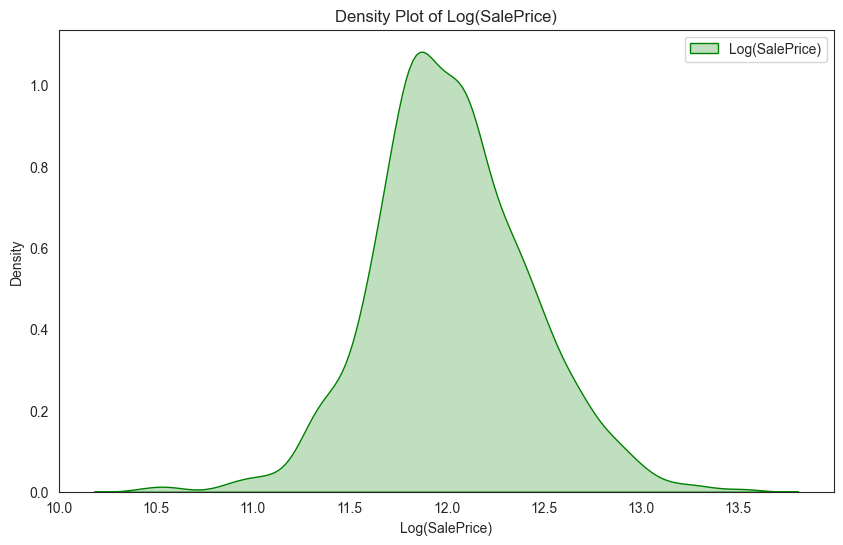

In [239]:
# Visualize distribution of log transformed target variable
data['SalePrice'] = np.log1p(data['SalePrice']) # not a form of information leakage

plt.figure(figsize=(10, 6))
sns.kdeplot(data['SalePrice'], shade=True, color='green', label='Log(SalePrice)')
plt.title('Density Plot of Log(SalePrice)')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Density')
plt.legend()
plt.show()

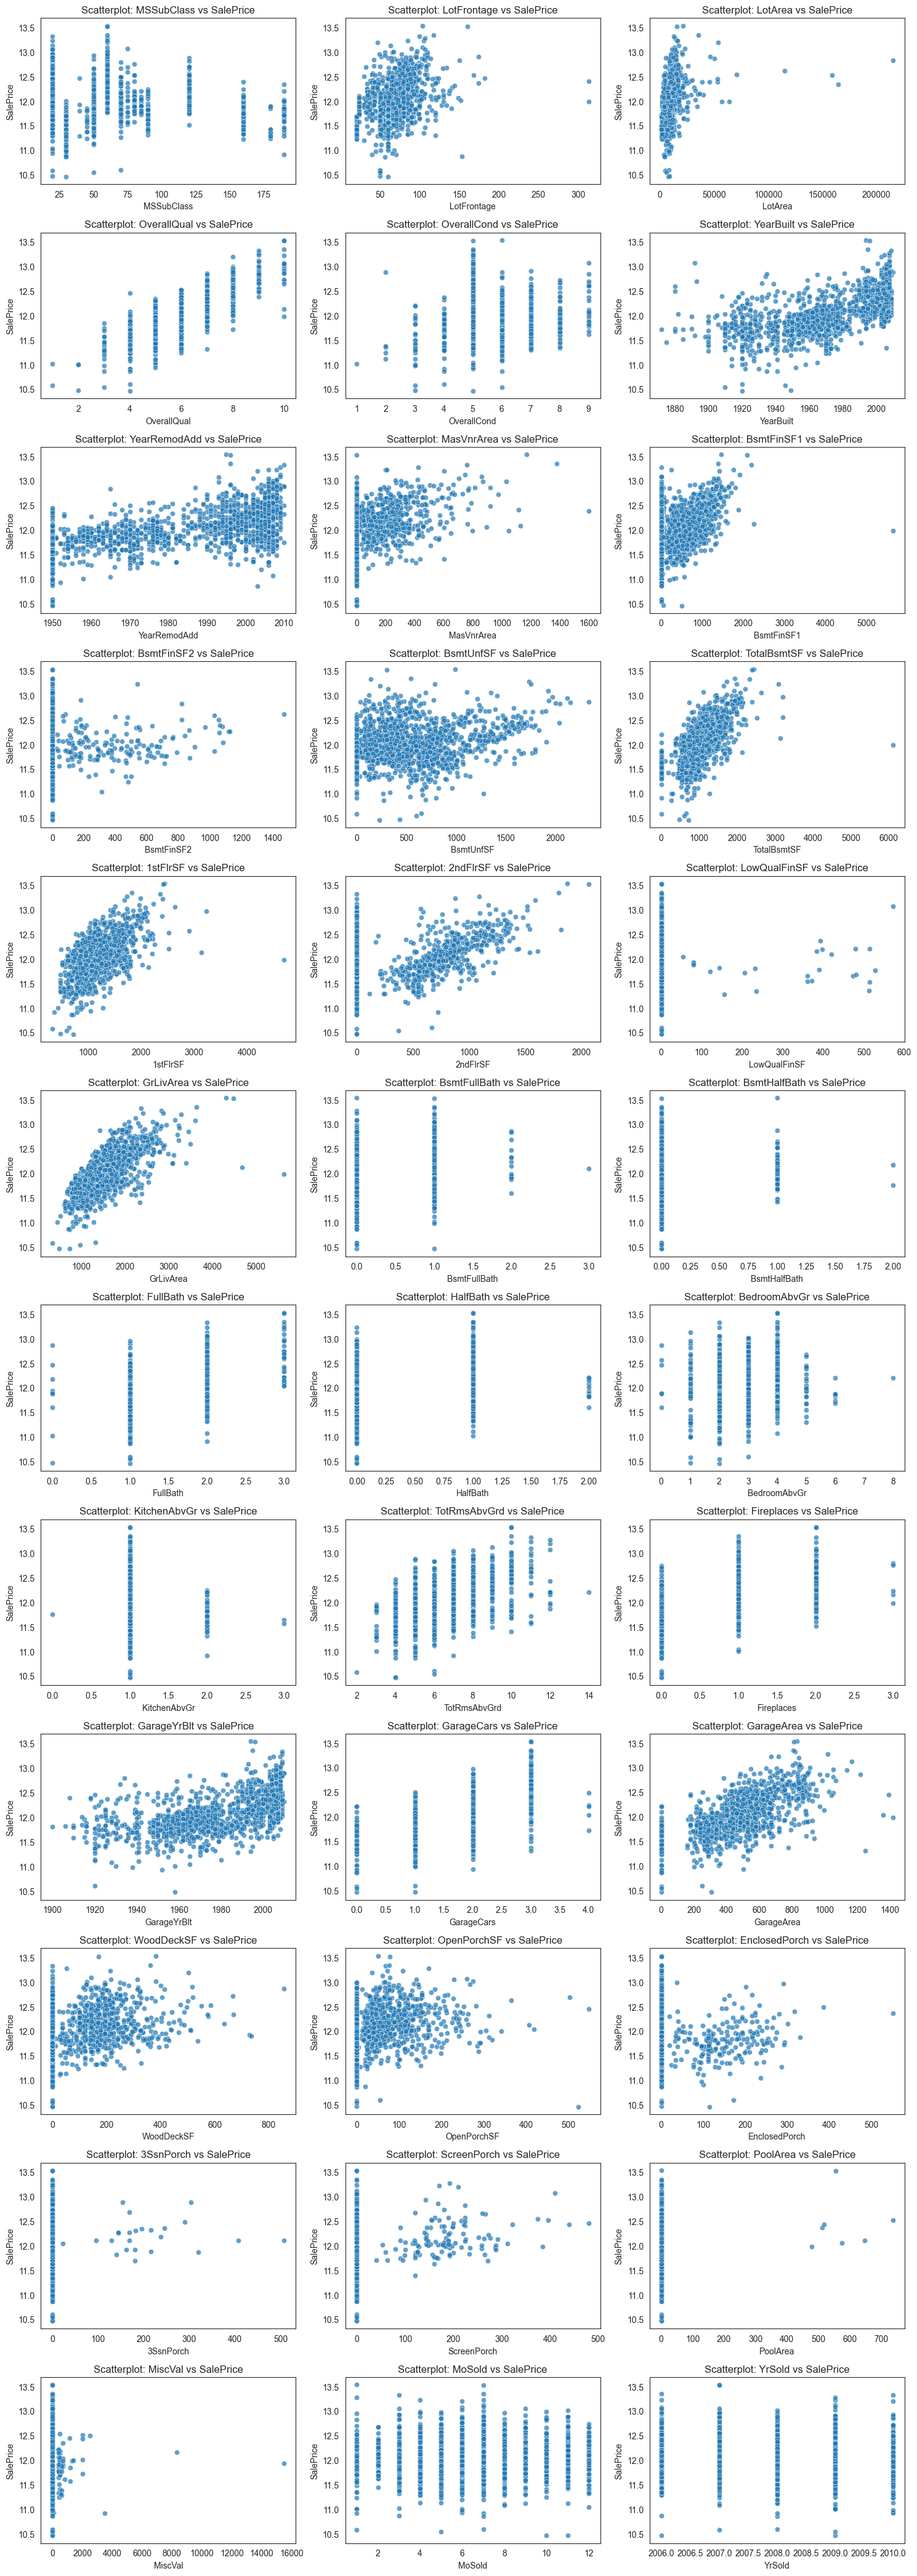

In [240]:
# Scatterplots for numeric columns
numeric_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_data = data.select_dtypes(include=numeric_types)

plt.figure(figsize=(15, 45))

# Create scatterplots for each numeric column
for i, column in enumerate(numeric_data.columns):
    if column != 'SalePrice':  # Avoid plotting SalePrice against itself
        plt.subplot((len(numeric_data.columns) - 1) // 3 + 1, 3, i + 1)  # Arrange the plots in a grid
        sns.scatterplot(x=numeric_data[column], y=numeric_data['SalePrice'], alpha=0.7)
        plt.title(f'Scatterplot: {column} vs SalePrice')
        plt.xlabel(column)
        plt.ylabel('SalePrice')

# Adjust layout for better display
plt.tight_layout()
plt.show()

Object Columns:
 Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


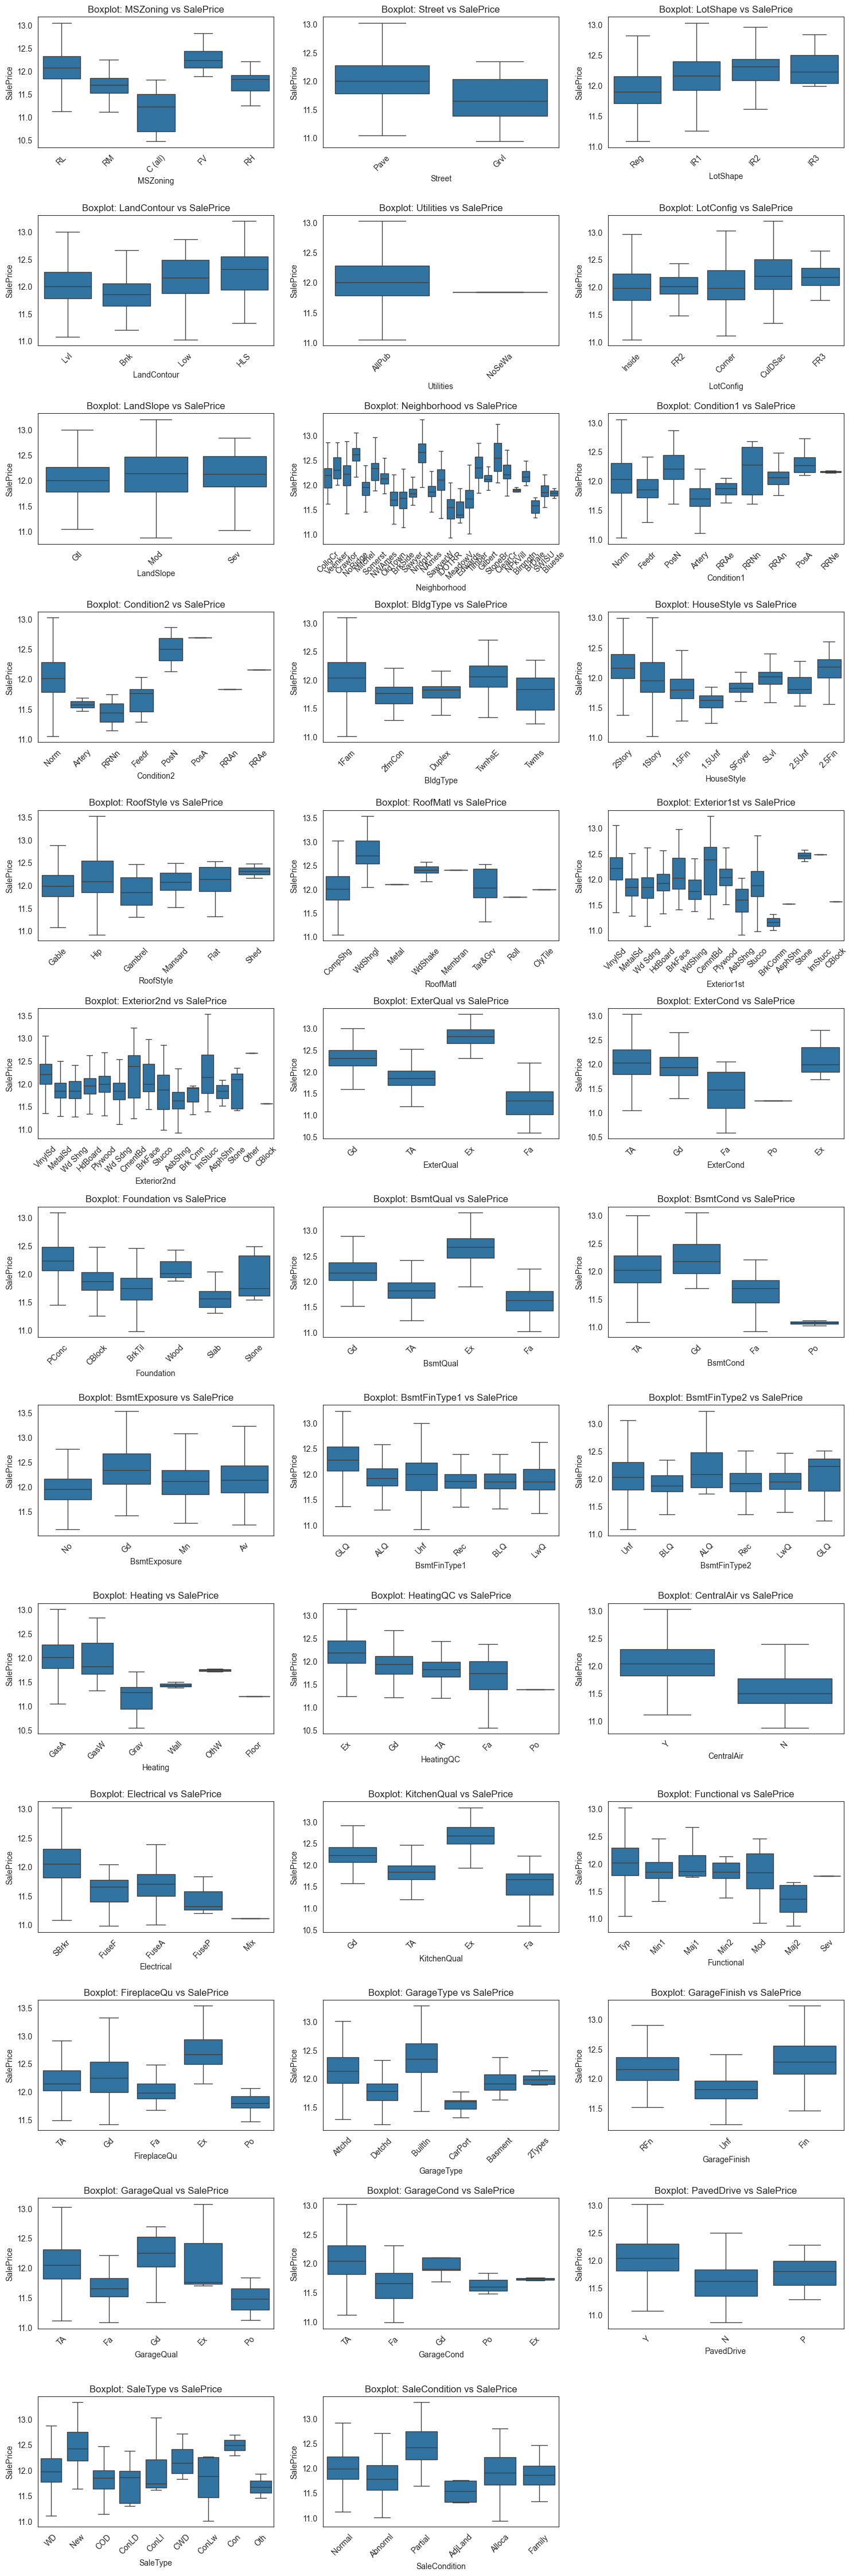

In [241]:
# Boxplots for categorical columns
categorical_data = data.select_dtypes(include=['object'])
print("Object Columns:\n", categorical_data.columns)

# Set up the figure for subplots
plt.figure(figsize=(15, 45))  # Set the figure size

# Create boxplots for each categorical column
for i, column in enumerate(categorical_data.columns):
    plt.subplot((len(categorical_data.columns) - 1) // 3 + 1, 3, i + 1)  # Arrange the plots in a grid
    sns.boxplot(x=categorical_data[column], y=data['SalePrice'], showfliers=False)
    plt.title(f'Boxplot: {column} vs SalePrice')
    plt.xlabel(column)
    plt.ylabel('SalePrice')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

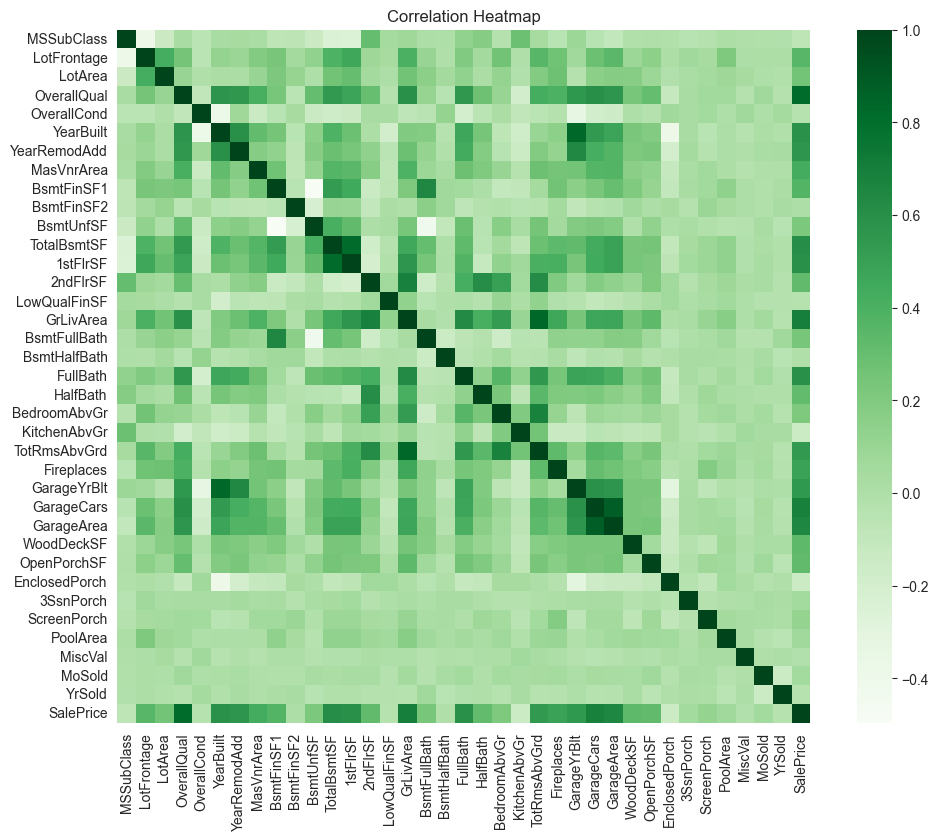

In [242]:
# Correlation matrix (heatmap) for numeric variables
cor_matrix = numeric_data.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(cor_matrix, cmap='Greens', cbar=True, square=True)
plt.title("Correlation Heatmap")
plt.show()

Impute missing data

In [243]:
# Check missing data
null_counts = data.isnull().sum()
null_columns = null_counts[null_counts > 0]

# Printing the columns and their respective null value counts
print("Columns that contain missing values:")
for column, null_count in null_columns.items():
    print(f"Column: {column}, Column type: {data[column].dtype}, Null Values: {null_count}")

print("Missing values in target variables:", data['SalePrice'].isnull().sum())

# Median impute for numeric data
for column in numeric_data.columns:
    median_value = data[column].median()
    data[column].fillna(median_value, inplace=True)

# Mode impute for categorical data
for column in categorical_data.columns:
    mode_value = data[column].mode()[0]  # Get the most frequent category
    data[column].fillna(mode_value, inplace=True)

Columns that contain missing values:
Column: LotFrontage, Column type: float64, Null Values: 259
Column: MasVnrArea, Column type: float64, Null Values: 8
Column: BsmtQual, Column type: object, Null Values: 37
Column: BsmtCond, Column type: object, Null Values: 37
Column: BsmtExposure, Column type: object, Null Values: 38
Column: BsmtFinType1, Column type: object, Null Values: 37
Column: BsmtFinType2, Column type: object, Null Values: 38
Column: Electrical, Column type: object, Null Values: 1
Column: FireplaceQu, Column type: object, Null Values: 690
Column: GarageType, Column type: object, Null Values: 81
Column: GarageYrBlt, Column type: float64, Null Values: 81
Column: GarageFinish, Column type: object, Null Values: 81
Column: GarageQual, Column type: object, Null Values: 81
Column: GarageCond, Column type: object, Null Values: 81
Missing values in target variables: 0


C:\Users\rtesi\AppData\Local\Temp\ipykernel_24192\1919281088.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(median_value, inplace=True)
C:\Users\rtesi\AppData\Local\Temp\ipykernel_24192\1919281088.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

Check for multicollinearity

In [244]:
features = data.drop(columns=['SalePrice'])
target = data['SalePrice']
numeric_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_feature_data = features.select_dtypes(include=numeric_types)

# Add a constant column to the numeric features
numeric_feature_data = add_constant(numeric_feature_data)

# Perform VIF calculation
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Variable'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Remove collinear features recursively based on VIF
def remove_collinear_features(df, threshold=5):
    vif_data = calculate_vif(df)
    removed_features = []

    while vif_data['VIF'].max() > threshold:
        # Find the feature with the highest VIF and remove it
        max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
        print(f"Removing feature {max_vif_feature} with VIF = {vif_data['VIF'].max()}")
        
        # Drop the feature from the dataset
        df = df.drop(columns=[max_vif_feature])
        
        removed_features.append(max_vif_feature)

        # Recalculate VIF after removal
        vif_data = calculate_vif(df)
    
    return df, removed_features

# Remove collinear features from numeric_feature_data
data_no_multicollinearity, features_removed_through_VIF = remove_collinear_features(numeric_feature_data, threshold=5)
print("Number of collinear features removed:", len(features_removed_through_VIF))

c:\Users\rtesi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature BsmtFinSF1 with VIF = inf


c:\Users\rtesi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature 1stFlrSF with VIF = inf
Removing feature const with VIF = 2416275.583304302
Removing feature YrSold with VIF = 24049.839767010235
Removing feature GarageYrBlt with VIF = 20489.827136693515
Removing feature YearRemodAdd with VIF = 13594.890004738721
Removing feature YearBuilt with VIF = 116.86148537933846
Removing feature GrLivArea with VIF = 99.4335848596999
Removing feature TotRmsAbvGrd with VIF = 67.47495824390025
Removing feature OverallQual with VIF = 48.408402635878566
Removing feature GarageCars with VIF = 34.3739166207715
Removing feature KitchenAbvGr with VIF = 25.20183870924469
Removing feature TotalBsmtSF with VIF = 22.257554168467035
Removing feature BedroomAbvGr with VIF = 19.222397853721127
Removing feature FullBath with VIF = 14.71310207030877
Removing feature LotFrontage with VIF = 13.033362779760305
Removing feature OverallCond with VIF = 9.958883035642948
Removing feature GarageArea with VIF = 7.11941800363476
Number of collinear features removed: 18


Dummy encoding

In [245]:
# Perform dummy encoding
features_removed_through_VIF.remove('const')
data_post_multicollinearity_removal = data.drop(features_removed_through_VIF, axis=1)
categorical_data_columns_post_multicollinearity_removal = data_post_multicollinearity_removal.select_dtypes(include=['object']).columns
data_dummied = pd.get_dummies(data_post_multicollinearity_removal, columns=categorical_data_columns_post_multicollinearity_removal, drop_first=True)
data_dummied.reset_index(drop=True, inplace=True)

X = data_dummied.drop(columns='SalePrice', axis=1)
X.reset_index(drop=True, inplace=True)

y = data_dummied['SalePrice']

Split data

In [246]:
# We will use the train data set as provided by Kaggle are our main data, 
# and use the test set provided by Kaggle as a validation set to generate submission results
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize train and test sets independently
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test = pd.DataFrame(X_test_normalized, columns=X_test.columns)

Evaluation functions

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [247]:
# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)

#     # rmse = root_mean_squared_error(test_labels, predictions)
#     rmse_log = np.sqrt(mean_squared_error(test_labels, predictions))
#     mae = mean_absolute_error(test_labels, predictions)
#     r2 = r2_score(test_labels, predictions)

#     # Printing regression metrics
#     print('Mean Absolute Error: {:.2f}'.format(mae))
#     print('Root Mean Squared Error Log: {:.2f}'.format(rmse_log))
#     print('R^2 Score: {:.2f}'.format(r2)) 

In [248]:
# For final test evaluation
def rmse_log(true_y, predicted_y):
    return np.sqrt(mean_squared_error(true_y, predicted_y))

# For evaluating CV scores during training
def cv_rmse(model, training_features, training_target):
    # print("Fetching cross validated RMSE scores on training")
    rmse = np.sqrt(-cross_val_score(model, training_features, training_target, scoring="neg_mean_squared_error", cv=5))
    return (rmse)

In [249]:
# Prep parameter grid for gridsearch on models in the pipeline
param_grids = {
    'lasso': {
        'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__max_iter': [1000, 5000, 10000],
        'model__tol': [1e-4, 1e-3, 1e-2]
    },
    'ridge': {
        'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__max_iter': [1000, 5000, 10000],
        'model__tol': [1e-4, 1e-3, 1e-2],
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    # 'xgboost': {
    #     'model__n_estimators': [50, 100, 200],
    #     'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    #     'model__max_depth': [3, 5, 7, 10],
    #     'model__subsample': [0.6, 0.8, 1.0],
    #     'model__colsample_bytree': [0.6, 0.8, 1.0],
    #     'model__gamma': [0, 1, 5],
    #     'model__reg_alpha': [0, 0.1, 1],
    #     'model__reg_lambda': [0.1, 1, 10]
    # },
    # 'gradient_boosting': {
    #     'model__n_estimators': [50, 100, 200],
    #     'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    #     'model__max_depth': [3, 5, 7, 10],
    #     'model__subsample': [0.6, 0.8, 1.0],
    #     'model__min_samples_split': [2, 5, 10],
    #     'model__min_samples_leaf': [1, 2, 4],
    #     'model__max_features': ['sqrt', 'log2', None]
    # },
}

# Pipeline with 4 models
models = {
    'lasso': Pipeline([
        ('scaler', RobustScaler()),
        ('model', Lasso(random_state=42))
    ]),
    'ridge': Pipeline([
        ('scaler', RobustScaler()),  # Add a scaler since Ridge is also sensitive to feature scaling
        ('model', Ridge(random_state=42))
    ]),
    # 'xgboost': Pipeline([
    #     ('model', XGBRegressor(random_state=42))
    # ]),
    # 'gradient_boosting': Pipeline([
    #     ('model', GradientBoostingRegressor(random_state=42))
    # ])
}

best_models = {}

for model, pipeline in models.items():
    print(f"Grid search started for {model}")

    # Find the best hyperparameters for the model
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grids[model], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[model] = grid.best_estimator_

    # Print metrics
    print(f"Best {model} params: {grid.best_params_}")
    # print(f"Best cross-validation MSE score: {-grid.best_score_}")

# Gather the best models for stacking
lasso = best_models['lasso']
ridge = best_models['ridge']
# xgb = best_models['xgboost']
# gbr = best_models['gradient_boosting']

# Stacking
stack_gen = StackingRegressor(
    estimators=[('lasso', lasso), ('ridge', ridge)], 
    final_estimator=Ridge(random_state=42),  # Replace with Ridge or another model as final estimator
    cv=5,
)

scores = {}
regressors = {"Lasso": lasso, 
                "Ridge": ridge,
                # "XGB_Regressor": xgb, 
                # "GB_Regressor": gbr
             }

print("Metrics for individual regressor:")
for name, regressor in regressors.items():
    predictions = regressor.predict(X_test)

    score = cv_rmse(regressor, X_train, y_train)  # Array of cross-validated RMSE scores
    print(f"{name} training mean RMSE from 5 fold CV: {score.mean():.4f} ({score.std():.4f})")
    scores[name] = (score.mean(), score.std())

    log_rmse = rmse_log(true_y=y_test, predicted_y=predictions)  # Array of cross-validated RMSE scores testing
    print(f"{name} testing mean RMSE from 5 fold CV: {log_rmse.mean():.4f} ({log_rmse.std():.4f})")

print("Metrics for stacking regressor:")
stack_gen.fit(X_train, y_train)
predictions = stack_gen.predict(X_test)
score = cv_rmse(stack_gen, X_train, y_train)  # Array of cross-validated RMSE scores
print(f"Stacking training mean RMSE from 5 fold CV: {score.mean():.4f} ({score.std():.4f})")
scores[name] = (score.mean(), score.std())

log_rmse = rmse_log(true_y=y_test, predicted_y=predictions)  # Array of cross-validated RMSE scores testing
print(f"Stacking testing mean RMSE from 5 fold CV: {log_rmse.mean():.4f} ({log_rmse.std():.4f})")

Grid search started for lasso
Best lasso params: {'model__alpha': 0.001, 'model__max_iter': 1000, 'model__tol': 0.01}
Grid search started for ridge
Best ridge params: {'model__alpha': 100, 'model__max_iter': 1000, 'model__solver': 'svd', 'model__tol': 0.0001}
Metrics for individual regressor:
Lasso training mean RMSE from 5 fold CV: 0.1805 (0.0132)
Lasso testing mean RMSE from 5 fold CV: 0.1753 (0.0000)
Ridge training mean RMSE from 5 fold CV: 0.1844 (0.0148)
Ridge testing mean RMSE from 5 fold CV: 0.1773 (0.0000)
Metrics for stacking regressor:
Stacking training mean RMSE from 5 fold CV: 0.1809 (0.0140)
Stacking testing mean RMSE from 5 fold CV: 0.1766 (0.0000)
